# <center> Raport firmy GWINTEX S.A.
## <center> Analiza optymalnej liczby zestawów narzędziowych w zależności od kosztów przestoju i kosztów zestawu narzędzi

<br>Zaawansowane Modelowanie Symulacyjne
<br>234060-0723

**Autorzy**
<br>Filip Mordarski, 76671 
<br>Damian Głowacki, 72384 
<br>Mateusz Dalba, 68734
<br>Dorota Szczęsna, 72569

In [55]:
import numpy as np
import random
import scipy as sc
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

In [25]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# liczba zestawów narzędzi
m = 6

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 10

# koszt jednostkowy
c = 1.5

# koszt instalacji
cost_inst = 500

# koszt narzedzia
m_cost = 2

In [26]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, seed):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    sc.random.seed(seed)
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji - najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    #koszt instalacji
    cost_inst = cost_inst if setup=='G' else 0
    
    #koszt narzedzi
    m_costs = m * m_cost
     
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machines = []
        for i in range(len(events)):
            if events[i] == t:
                machines.append(i)
        machine = machines[random.randint(0, len(machines)-1)]
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("Niepoprawny układ! Należy wybrać układ 'L' lub 'G'!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("zly uklad - moze byc L lub G!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    t_cost = [t*c for t in t_cum]
    cost = cost_inst + sum(t_cost) + m_costs
    # wynik skumulowany czas oraz koszt
    return (t_cum, cost)

In [27]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost):
    avg_t_cum = []
    avg_t_cost = []
    for i in range (iterations):
        x = model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, i)
        avg_t_cum.append(x[0])
        avg_t_cost.append(x[1])
    return (list(map(np.mean, np.transpose(avg_t_cum))), np.mean(avg_t_cost))


In [30]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "G", c, cost_inst, m_cost)

([8390.637514613913,
  8395.094837177927,
  8433.027881939739,
  8236.714849328893,
  8369.477794785194,
  8385.589987503561],
 75827.81429802383)

## 5. Wyniki analizy

<br> W tej części raportu zostaną przedstawione wyniki analizy, które mają na celu wskazać optymalną liczbę zestawów narzędzi w zależności od kosztów przestoju i kosztów zestawu narzędzi. Jak zostało powyżej wspomniane, przedsiębiorstwo ma dwie możliwości rozmieszczenia urządzeń na hali produkcyjnej, w układzie liniowym lub gniazdowym. Z tego względu poniższa analiza będzie uwzględniała również te obie możliwości rozmieszczenia. W poszukiwaniu optymalnej liczby zestawu narzędzi, przyjmiemy że koszt instalacji układu gniazdowego jest stały i wynosi 20,000 jednostek. Koszt jednostkowy za jedną jednostkę czasu przestoju będzie badany z zakresu wartości <5;20> z granulacją co 5), natomiast koszt jednego zestawu narzędzi z przedziału <10000;50000> z granulacją co 10000). Z opisu problemu wynika, że liczba zestawów narzędzi nie powinna być wyższa niż liczba maszyn. Z tego względu analizowana będzie liczba zestawów narzędzi z przedziału (1;6).

In [42]:
unit_costs = range(5, 21, 5)
machine_costs = range(10000, 50001, 10000)
machines = range(1, 7)
results = {}
cost_inst = 20000
data = pd.DataFrame()

for m in machines:
    for c in unit_costs:
        for m_cost in machine_costs:
            results[(m, c, m_cost, "G")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "G", c, cost_inst, m_cost)[1]
            results[(m, c, m_cost, "L")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "L", c, cost_inst, m_cost)[1]
            print("Dla liczby zestawów narzędzi równej ", m,
                  "oraz kosztu jednostkowego przestoju: ", c, "i kosztu zestawu narzędzi: ", 
                  m_cost, " całkowity koszt w układzie liniowym wynosi: ", round(results[(m, c, m_cost, "L")], 2),
                  ", natomiast w układzie gniazdowym: ", round(results[(m, c, m_cost, "G")], 2), "\n")
            data = data.append({"Liczba maszyn": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "G",
                            "Calkowity koszt": results[(m, c, m_cost, "G")]}, ignore_index=True)
            data = data.append({"Liczba maszyn": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "L",
                            "Calkowity koszt": results[(m, c, m_cost, "L")]}, ignore_index=True)

Dla liczby zestawów narzędzi równej  1 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  10000  całkowity koszt w układzie liniowym wynosi:  750398.44 , natomiast w układzie gniazdowym:  585861.34 

Dla liczby zestawów narzędzi równej  1 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  20000  całkowity koszt w układzie liniowym wynosi:  761935.39 , natomiast w układzie gniazdowym:  595898.83 

Dla liczby zestawów narzędzi równej  1 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  30000  całkowity koszt w układzie liniowym wynosi:  771051.24 , natomiast w układzie gniazdowym:  605851.03 

Dla liczby zestawów narzędzi równej  1 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  40000  całkowity koszt w układzie liniowym wynosi:  780225.81 , natomiast w układzie gniazdowym:  615834.07 

Dla liczby zestawów narzędzi równej  1 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  50000  całkowity koszt w 

Dla liczby zestawów narzędzi równej  2 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  40000  całkowity koszt w układzie liniowym wynosi:  1627591.13 , natomiast w układzie gniazdowym:  1299288.59 

Dla liczby zestawów narzędzi równej  2 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  50000  całkowity koszt w układzie liniowym wynosi:  1663508.19 , natomiast w układzie gniazdowym:  1319317.19 

Dla liczby zestawów narzędzi równej  3 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  10000  całkowity koszt w układzie liniowym wynosi:  340191.16 , natomiast w układzie gniazdowym:  305375.84 

Dla liczby zestawów narzędzi równej  3 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  20000  całkowity koszt w układzie liniowym wynosi:  372651.89 , natomiast w układzie gniazdowym:  335375.84 

Dla liczby zestawów narzędzi równej  3 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  30000  całkowity ko

Dla liczby zestawów narzędzi równej  4 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  20000  całkowity koszt w układzie liniowym wynosi:  1265671.09 , natomiast w układzie gniazdowym:  1100697.93 

Dla liczby zestawów narzędzi równej  4 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  30000  całkowity koszt w układzie liniowym wynosi:  1298775.0 , natomiast w układzie gniazdowym:  1140697.93 

Dla liczby zestawów narzędzi równej  4 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  40000  całkowity koszt w układzie liniowym wynosi:  1343222.99 , natomiast w układzie gniazdowym:  1180697.93 

Dla liczby zestawów narzędzi równej  4 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  50000  całkowity koszt w układzie liniowym wynosi:  1380183.64 , natomiast w układzie gniazdowym:  1220697.93 

Dla liczby zestawów narzędzi równej  5 oraz kosztu jednostkowego przestoju:  5 i kosztu zestawu narzędzi:  10000  całkowi

Dla liczby zestawów narzędzi równej  6 oraz kosztu jednostkowego przestoju:  15 i kosztu zestawu narzędzi:  50000  całkowity koszt w układzie liniowym wynosi:  1174248.16 , natomiast w układzie gniazdowym:  1073158.14 

Dla liczby zestawów narzędzi równej  6 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  10000  całkowity koszt w układzie liniowym wynosi:  1225664.21 , natomiast w układzie gniazdowym:  1084210.86 

Dla liczby zestawów narzędzi równej  6 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  20000  całkowity koszt w układzie liniowym wynosi:  1285664.21 , natomiast w układzie gniazdowym:  1144210.86 

Dla liczby zestawów narzędzi równej  6 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  30000  całkowity koszt w układzie liniowym wynosi:  1345664.21 , natomiast w układzie gniazdowym:  1204210.86 

Dla liczby zestawów narzędzi równej  6 oraz kosztu jednostkowego przestoju:  20 i kosztu zestawu narzędzi:  40000  całko

In [51]:
data_l

,index,Calkowity koszt,Koszt jedn.,Koszt zestawu,Liczba maszyn,Ustawienie
0,1,7.503984e+05,5.0,10000.0,1.0,L
1,3,7.619354e+05,5.0,20000.0,1.0,L
2,5,7.710512e+05,5.0,30000.0,1.0,L
3,7,7.802258e+05,5.0,40000.0,1.0,L
4,9,7.891097e+05,5.0,50000.0,1.0,L
...,...,...,...,...,...,...
115,231,1.225664e+06,20.0,10000.0,6.0,L
116,233,1.285664e+06,20.0,20000.0,6.0,L
117,235,1.345664e+06,20.0,30000.0,6.0,L
118,237,1.405664e+06,20.0,40000.0,6.0,L


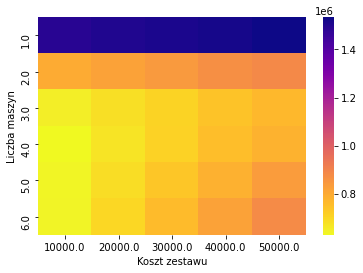

In [57]:
data_l = data[(data['Ustawienie']=='L') & (data['Koszt jedn.']==15)].reset_index()
data_g = data[data['Ustawienie']=='G']
df_pivot_l = data_l.pivot("Liczba maszyn", "Koszt zestawu", "Calkowity koszt")
sns.heatmap(df_pivot_l, cmap=cm.plasma_r)